<a href="https://colab.research.google.com/github/GUmarEla/feature-_detection/blob/main/02_CornerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intrduction**

Corner Detection Algorithms

*   Shi_Tomasi(image, kernel_size, sigma, alpha)
*   List item
*   harris(image, k, alpha, gaussian_kernel_size, gaussian_sigma)
*   List item





**Import libraries**

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# **Load Image**

In [ ]:
# Import necessary libraries
import numpy as np
import requests
import cv2

# Define the image URL
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR2N9OK2YKfUJp-zElKfTpuBbrUSfn1YFqp7A&s'

# Download the image
response = requests.get(url)
img_data = response.content

# Convert image data to a NumPy array
img_array = np.frombuffer(img_data, np.uint8)

# Decode the images
image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# **Corner Detection Algorithms**

## Shi-Thomasi

In [ ]:
import numpy as np
from scipy.signal import convolve2d
import cv2

# Define Gaussian kernel function
def gaussian_kernel(kernel_size : int,
                    sigma: float):
    kernel = np.zeros((kernel_size, kernel_size))
    x_center = y_center = kernel_size // 2
    constant = 1 / (2 * np.pi * sigma**2)

    for i in range(kernel_size):
        for j in range(kernel_size):
            i_new = i - x_center
            j_new = j - y_center
            distance = i_new ** 2 + j_new ** 2
            kernel[i, j] = constant * np.exp(-distance / (2 * sigma**2))

    kernel /= np.sum(kernel)  # Normalize the kernel
    return kernel

# Shi-Tomasi corner detection function
def Shi_Tomasi(image : np.ndarray,
               kernel_size : int,
               sigma : float,
               alpha : float):
    # Convert to grayscale if image has RGB channels
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Convert image to float for precision
    image = np.float32(image)

    # Compute gradients in x and y directions
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Compute products of gradients
    Ixx = gradient_x ** 2
    Iyy = gradient_y ** 2
    Ixy = gradient_x * gradient_y

    # Gaussian smoothing step
    gssn_krnl = gaussian_kernel(kernel_size=kernel_size, sigma=sigma)
    Sxx = convolve2d(Ixx, gssn_krnl, mode='same', boundary='symm')
    Syy = convolve2d(Iyy, gssn_krnl, mode='same', boundary='symm')
    Sxy = convolve2d(Ixy, gssn_krnl, mode='same', boundary='symm')

    # Compute eigenvalues for each pixel location
    Sxx_flat = Sxx.flatten()
    Syy_flat = Syy.flatten()
    Sxy_flat = Sxy.flatten()

    matrices_flat = np.array([Sxx_flat, Sxy_flat, Sxy_flat, Syy_flat]).T.reshape(-1, 2, 2)
    eigenvalues_flat = np.linalg.eigvals(matrices_flat)

    # Calculate minimum eigenvalue for each pixel location
    min_eigenvalues_flat = np.min(eigenvalues_flat, axis=1)
    R = min_eigenvalues_flat.reshape(Sxx.shape)

    # Define threshold and create the result image based on it
    threshold = alpha * R.max()
    image_result = np.where(R > threshold, 1, 0)

    # Convert result to uint8 format for consistency
    image_result = image_result.astype(np.uint8)

    return image_result


(-0.5, 231.5, 216.5, -0.5)

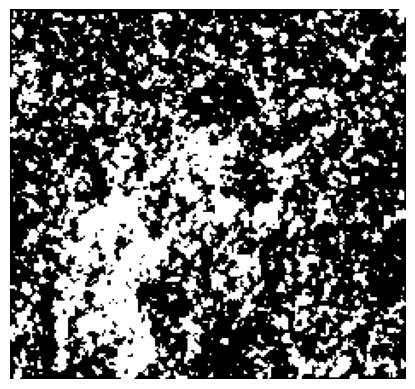

In [ ]:
plt.imshow(Shi_Tomasi(image_gray, kernel_size = 5, sigma = 1, alpha = .05),
           cmap='gray')
plt.axis('off')

## FAST (Features from Accelerated Segment Test)

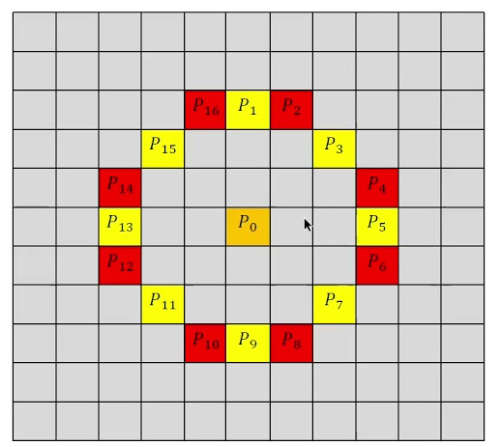

In [ ]:
import numpy as np

def FAST(image, i, j, threshold, n):
    # Define 16 pixel positions as offsets from the center pixel (i, j)
    offsets = [(0, -3), (1, -3), (2, -2), (3, -1), (3, 0), (3, 1), (2, 2), (1, 3),
               (0, 3), (-1, 3), (-2, 2), (-3, 1), (-3, 0), (-3, -1), (-2, -2), (-1, -3)]

    # Get pixel values in a circular pattern around the center pixel
    pixel_values = [image[i + oi, j + oj] for oi, oj in offsets]

    # Center pixel value
    Ip = image[i, j]

    # First step: Check if at least 9 contiguous pixels are either all brighter or all darker than Ip ± threshold
    list_brighter = 0
    list_darker = 0
    for idx in range(16):
        if pixel_values[idx] > Ip + threshold:
            list_brighter += 1
        elif pixel_values[idx] < Ip - threshold:
            list_darker += 1

    # If neither condition is met, it is not a corner
    if (list_brighter < n) and (list_darker < n):
        return False  # Not a corner

    # Now check contiguous pixels, ensuring there is a streak of at least `n` pixels
    def check_contiguous(n, pixel_values, condition_func):
        count = 0
        for idx in range(16):
            if condition_func(pixel_values[idx], Ip, threshold):
                count += 1
                if count >= n:
                    return True
            else:
                count = 0
        return False

    # Condition functions for brighter and darker checks
    def is_brighter(pixel_value, Ip, threshold):
        return pixel_value > Ip + threshold

    def is_darker(pixel_value, Ip, threshold):
        return pixel_value < Ip - threshold

    # Check if there are `n` contiguous pixels that are brighter or darker
    if check_contiguous(n, pixel_values, is_brighter) or check_contiguous(n, pixel_values, is_darker):
        return True  # Corner detected

    return False  # Not a corner

In [ ]:
FAST(image_gray, 100, 100, 3, 12)

False

## Harris

In [ ]:
import numpy as np
import cv2
from scipy.signal import convolve2d

# Define a Gaussian kernel generator function
def gaussian_kernel(kernel_size : int,
                    sigma : float):
    ax = np.linspace(-(kernel_size - 1) // 2, (kernel_size - 1) // 2, kernel_size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
    return kernel / np.sum(kernel)  # Normalize the kernel

def harris(image : np.ndarray,
           k : float,
           alpha : float,
           gaussian_kernel_size : int,
           gaussian_sigma : float):
    # Convert image to grayscale if it's in RGB
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = np.float32(image)  # Convert to float for precise computation

    # Compute gradients using Sobel operators (better than simple [-1, 0, 1] kernels)
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Compute products of gradients
    Ixx = gradient_x ** 2
    Iyy = gradient_y ** 2
    Ixy = gradient_x * gradient_y

    # Apply Gaussian smoothing to these gradient products
    gsn_krnl = gaussian_kernel(kernel_size=gaussian_kernel_size, sigma=gaussian_sigma)

    Sxx = convolve2d(Ixx, gsn_krnl, mode='same', boundary='symm')
    Syy = convolve2d(Iyy, gsn_krnl, mode='same', boundary='symm')
    Sxy = convolve2d(Ixy, gsn_krnl, mode='same', boundary='symm')

    # Compute Harris corner response
    det_M = (Sxx * Syy) - (Sxy ** 2)
    trace_M = Sxx + Syy
    R = det_M - k * (trace_M ** 2)

    # Thresholding to find corners (you can adjust the threshold value)
    threshold = alpha * R.max()
    corners = np.zeros_like(R)
    corners[R > threshold] = 1

    # Non-maximum suppression (to refine the corner detection)
    corners = cv2.dilate(corners, None)  # Dilate to identify local maxima
    strong_corners = np.where((R == cv2.dilate(R, None)) & (R > threshold), 255, 0).astype(np.uint8)

    return strong_corners

(-0.5, 231.5, 216.5, -0.5)

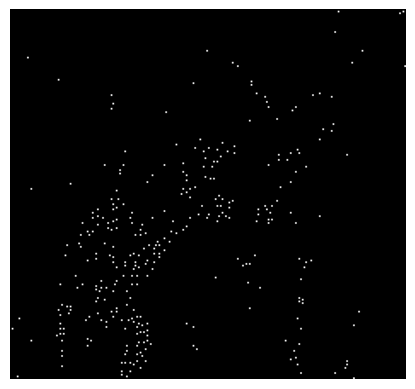

In [ ]:
plt.imshow(harris(image_gray,
                  k = .05,
                  alpha = .04,
                  gaussian_kernel_size =3,
                  gaussian_sigma = .6), cmap='gray')
plt.axis(False)

## SUSAN (Smallest Univalue Segment Assimilating Nucleus)

In [ ]:
import numpy as np
import cv2
from typing import List, Tuple, Optional

def create_circular_mask(radius: int) -> List[Tuple[int, int]]:
    """
    Create a circular neighborhood mask coordinates.

    Args:
        radius (int): Radius of the circular mask

    Returns:
        List[Tuple[int, int]]: List of relative coordinates in the mask
    """
    if radius not in [3, 5]:
        raise ValueError("Radius must be 3 or 5")

    if radius == 3:
        return [
            (-1, 0), (1, 0), (0, -1), (0, 1),
            (-1, -1), (-1, 1), (1, -1), (1, 1)
        ]
    else:  # radius == 5
        return [
            (-1, 0), (1, 0), (0, -1), (0, 1),
            (-1, -1), (-1, 1), (1, -1), (1, 1),
            (-2, -1), (-2, 0), (-2, 1),
            (2, -1), (2, 0), (2, 1),
            (-1, 2), (0, 2), (1, 2),
            (-1, -2), (0, -2), (1, -2)
        ]

def susan_response(
    image: np.ndarray,
    i: int,
    j: int,
    radius: int,
    threshold: float,
    corner_threshold: float
) -> float:
    """
    Compute SUSAN corner response for a pixel.

    Args:
        image (np.ndarray): Input image
        i (int): Row coordinate of the pixel
        j (int): Column coordinate of the pixel
        radius (int): Radius of the neighborhood
        threshold (float): Intensity similarity threshold
        corner_threshold (float): Threshold for corner detection

    Returns:
        float: Corner response value
    """
    # Ensure grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Convert to float for precision
    image = image.astype(np.float32)

    # Create mask coordinates
    mask_coords = create_circular_mask(radius)

    # Compute pixel similarities
    nucleus_intensity = image[i, j]
    similarities = []

    for oi, oj in mask_coords:
        try:
            neighbor_intensity = image[i + oi, j + oj]
            # Improved similarity computation
            if abs(neighbor_intensity - nucleus_intensity) < threshold:
                similarities.append(1)
            else:
                similarities.append(0)
        except IndexError:
            # Handle edge cases by skipping
            similarities.append(0)

    # Compute area metrics
    D = sum(similarities)  # Similar pixel count
    A = len(mask_coords)  # Total neighborhood pixels

    # Refined corner response calculation
    if D == 0:
        return 0.0

    # Geometric interpretation of corner response
    R = D * (1 - (D / A))

    return R

def susan(
    image: np.ndarray,
    pixel_list: Optional[List[Tuple[int, int]]] = None,
    radius: int = 3,
    threshold: float = 27.0,
    corner_threshold: float = 0.4
) -> np.ndarray:
    """
    Detect corners using SUSAN algorithm.

    Args:
        image (np.ndarray): Input image
        pixel_list (Optional[List[Tuple[int, int]]]): List of pixels to check
        radius (int): Radius of neighborhood
        threshold (float): Intensity similarity threshold
        corner_threshold (float): Threshold for corner detection

    Returns:
        np.ndarray: Binary image marking corners
    """
    # Pad image to handle border pixels
    dim = radius // 2
    padded_image = np.pad(image, dim, mode='reflect')

    # Generate pixel list if not provided
    if pixel_list is None:
        height, width = image.shape[:2]
        pixel_list = [
            (y, x) for y in range(dim, height + dim)
            for x in range(dim, width + dim)
        ]

    # Compute corner responses
    R_list = np.array([
        susan_response(
            padded_image,
            i, j,
            radius=radius,
            threshold=threshold,
            corner_threshold=corner_threshold
        ) for i, j in pixel_list
    ])

    # Apply thresholding
    if len(R_list) == 0:
        return np.zeros_like(image, dtype=np.uint8)

    # Dynamic thresholding based on response distribution
    Rth = corner_threshold * R_list.max()

    # Create corner map
    corners = np.zeros_like(image, dtype=np.uint8)
    for (y, x), response in zip(pixel_list, R_list):
        corners[y-dim, x-dim] = 1 if response > Rth else 0

    return corners

# Example usage
def detect_corners(image_path: str):
    """
    Demonstration of corner detection.

    Args:
        image_path (str): Path to input image
    """
    # Read image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Detect corners
    corners = susan(
        image,
        radius=3,
        threshold=27.0,
        corner_threshold=0.4
    )

    # Visualize corners
    result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    result[corners == 1] = [0, 0, 255]  # Mark corners in red

    # Display results
    cv2.imshow('Original Image', image)
    cv2.imshow('Detected Corners', result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()